# Facilities

- welcher Download? Ich habe die ganze Liste runtergeladen, da sind nur die Operating Facillites drin. In deinen zwei Downloads scheint auch Closed mit drin zu sein?
- welche states sind relevant? Es gibt kein Close Date, also unklar, in welcher Time-range man nicht Operating Facillites halten sollte
- => wie aggregieren? Einmal aktuellen stand zähen oder anhand des Opening Dates zählen per district? Wohin gehen die ohne Opnening Date? 
- map to district by lat/lng or try to extrapolate by region/district/council names?
- No data for zanzibar Archipelago (5 regions)!
- lat/lng coordindates are not always correct, some are invalid, some are outside tanzania (main stuff seems to be correct though, ~13 % (1343) have no coordinates
- some mismatches between given region name and provided coordinate (most look minor, but some are realy outside the district)
- Was fällt jeweils in welche categorie?
 - Dispensery Density
 - Health Center Density 
 - Clinic Density
 - Hospital Density
 - Health Lab Density
 
 
 Link der scheinabr alles runterläd: 
 
https://hfrportal.moh.go.tz/index.php?r=facilities/exportToExcel&url=http%3A%2F%2F41.59.227.72%2Findex.php%2Fapi%2Fhealth-facility%2Fadvance-search%3Fpage%3Dall%26Admin_div%3DTZ&report_title=+

http://41.59.227.72/api/health-facility/index auf der Seite liegen die daten da gibt es auch ein paar Kontakt infos:

http://41.59.227.72/site/login?active_tab=Welcome-Details-tab

ups...

yii framework

http://41.59.227.72/index.php/api/health-facility/advance-search


-> JSON Download mit mehr fehledern.

http://41.59.227.72/index.php/api/health-facility/advance-search?page=all&Admin_div=TZ&report_title=+

`Admin_div` kann verwendet werden um die Anzeige einzugrenzen, bswp. `TZ.LK.MZ.NA`


im excel export link steht die URL der API dhinter: 

https://hfrportal.moh.go.tz/index.php?r=facilities%2FadvancedSearch&SiteForm%5Bzone%5D=TZ.WT&SiteForm%5Bregion%5D=TZ.WT.SI&SiteForm%5Bdistrict%5D=TZ.WT.SI.MT&SiteForm%5Bcouncil%5D=&SiteForm%5Bnode_id%5D=TZ.WT.SI.MT&SiteForm%5Bfacility_type_categories%5D=DSP&SiteForm%5Bfacility_type%5D=&SiteForm%5Boperating_status%5D=Opert&SiteForm%5Bownership_categories%5D=&SiteForm%5Bownership_type%5D=&SiteForm%5Bequipment_list%5D=&SiteForm%5Bservice_offered%5D=&SiteForm%5Binfrastructure_category%5D=&SiteForm%5Bdate_from%5D=&SiteForm%5Bdate_to%5D=2022-04-28&yt0=Search

https://hfrportal.moh.go.tz/index.php?r=facilities/exportToExcel&url=http://41.59.227.72/index.php/api/health-facility/advance-search?page=all&Admin_div=TZ.WT.SI.MT&Fac_Type=DSP&OperatingStatus=Opert&report_title=+

-> 




---- 



- Kristopher macht mapping der facillity types
- Wir orientieren uns an den lat/lng Koordiaten (die textliche zuordnung ist die administrative ordnung VERMUTLICH, und nicht die geographische)
- alles ohne openening date summieren, dann entsprechend nach jahr addieren

In [1]:
import pandas as pd

# prevent false warning
# https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

import datetime as dt

import geopandas
from shapely.geometry import Point

import logging
import re


dateparse = lambda x: dt.datetime.strptime(x, '%Y-%m-%d')

In [2]:
from dbconf import get_engine

In [3]:
logging.basicConfig(filename='healtfacilites.log', encoding='utf-8', level=logging.INFO)


In [157]:
df = pd.read_html('../input/data.local/-2022-Apr-24__13_44_38.xls', 
                 header=1, na_values=['Not Set', 'NIL', 'NOT documented', 'not documented'])[0]

# date_parser throws error on read_html
# parse_dates=['Date Opened'], date_parser=dateparse

In [158]:
df['Operating Status'].value_counts(dropna=False).rename_axis('unique_values').reset_index(name='counts')

unique_values  counts
0                                   Operating   10209
1                            Permanent closed     784
2      Pending Operation - Under Construction     774
3   Pending Operation - Construction Complete     299
4                                   Finishing     128
5                            Temporary closed      93
6                                         NaN      80
7                                     Roofing      67
8                                        Wall      66
9                                  Foundation      34
10                                   Planning      15

In [163]:
df[df['Operating Status'] == 'Pending Operation - Under Construction']

ID Facility Number   Facility Name    Latitude  Longitude  \
163    1692        108587-7        ALENSONI    -6.95372   38.96669   
358    1989        114062-3           ARASH         NaN        NaN   
377    2016        110719-2    ARUSHA CHINI  -10.606036  40.143931   
421    2086        111719-1  AZIMIO MSWISWI         NaN        NaN   
446    2136        111914-8          BAGHAI         NaN        NaN   
...     ...             ...             ...         ...        ...   
12466  1655        111767-0        YENZEBWE         NaN        NaN   
12477  1678        113666-2            YULI         NaN        NaN   
12501  1737        115262-8          ZANZUI    -3.06303   33.51171   
12516  1768        115086-1          ZEPISA         NaN        NaN   
12523  1777        111480-0         ZIMBILI    -4.43965   38.34425   

               Common Name         Region             District        Council  \
163                 Kifuru   Pwani Region    Kisarawe District    Kisarawe DC   
358                    NaN  Arusha Region  Ngorongoro District  Ngorongoro DC   
377           Arusha chini  Mtwara Region      Mtwara District    Nanyamba TC   
421                    NaN   Mbeya Region     Mbarali District     Mbarali DC   
446                 Baghai   Tanga Region     Lushoto District     Lushoto DC   
...                    ...            ...                  ...            ...   
12466  Yenzebwe Dispensary  Songwe Region       Ileje District       Ileje DC   
12477                  NaN  Songwe Region       Ileje District       Ileje DC   
12501                  NaN  Simiyu Region       Maswa District       Maswa DC   
12516                  NaN  Dodoma Region      Dodoma District      Dodoma MC   
12523              Zimbili   Tanga Region     Lushoto District     Lushoto DC   

           Ward  ...                        Operating Status  \
163    Kisarawe  ...  Pending Operation - Under Construction   
358       Arash  ...  Pending Operation - Under Construction   
377       Chawi  ...  Pending Operation - Under Construction   
421     Kongolo  ...  Pending Operation - Under Construction   
446       Mlalo  ...  Pending Operation - Under Construction   
...         ...  ...                                     ...   
12466    Itumba  ...  Pending Operation - Under Construction   
12477     Mlale  ...  Pending Operation - Under Construction   
12501    Zanzui  ...  Pending Operation - Under Construction   
12516   Hombolo  ...  Pending Operation - Under Construction   
12523   Mbaramo  ...  Pending Operation - Under Construction   

                                    Ownership Date Opened  \
163    Faith Based Organization (FBO) Private  1970-01-01   
358                                LGA Public         NaN   
377                                LGA Public         NaN   
421                                LGA Public         NaN   
446                                LGA Public         NaN   
...                                       ...         ...   
12466                              LGA Public         NaN   
12477                              LGA Public         NaN   
12501                              LGA Public  2014-06-07   
12516                              LGA Public  1970-01-01   
12523                          LGA Public LGA  2020-07-07   

      Official Phone Number MTUHA CTC_ID  msd_id     PostalAddress  \
163               754015465   NaN    NaN     NaN         12107 DSM   
358                     NaN   NaN    NaN     NaN               NaN   
377                     NaN   NaN    NaN     NaN      P. o Pox 528   
421                     NaN   NaN    NaN     NaN               NaN   
446                     NaN   NaN    NaN     NaN   Box 66, Lushoto   
...                     ...   ...    ...     ...               ...   
12466                   NaN   NaN    NaN     NaN  P.O.BOX 12-ILEJE   
12477                   NaN   NaN    NaN     NaN               NaN   
12501                   NaN   NaN    NaN     NaN               

In [143]:
types_df = df['Facility Type'].value_counts(dropna=False).rename_axis('type').reset_index(name='counts')
# plot.pie(y='counts', labels='type')



<AxesSubplot:ylabel='counts'>

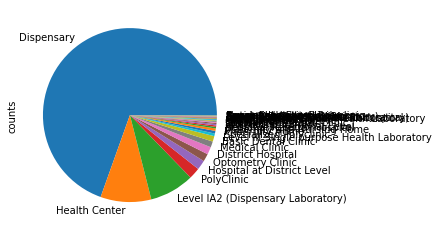

In [153]:
types_df.plot.pie(y='counts', labels=types_df['type'].values, legend=False)

In [154]:
types_df

type  counts
0                                   Dispensary    7099
1                                Health Center     962
2            Level IA2 (Dispensary Laboratory)     848
3                                   PolyClinic     214
4                   Hospital at District Level     181
5                             Optometry Clinic     147
6                            District Hospital     144
7                               Medical Clinic     111
8                          Basic Dental Clinic     105
9   Level III Single purpose Health Laboratory      50
10                      Specialized Polyclinic      50
11                              Maternity Home      46
12                  Maternity and Nursing Home      30
13                  Regional Referral Hospital      27
14                  Hospital at Regional Level      26
15                          Specialised Clinic      22
16                           Diagnostic Centre      16
17                   Specialised Dental Clinic      16
18                                  Eye Clinic      15
19                             Dialysis Clinic      15
20                     Hospital at Zonal Level      11
21                              General Clinic      11
22    Level III Multipurpose Health Laboratory       8
23                        Physiotherapy Clinic       8
24        Level IA1 (Health Center Laboratory)       7
25         National Super Specialized Hospital       6
26                 Comprehensive Dental Clinic       6
27                    Super Specialised Clinic       5
28            Level IIA2 (District Laboratory)       5
29                   Specimen Collection Point       5
30                     Zonal Referral Hospital       4
31                      Specialised Eye Clinic       3
32                Super Specialized Polyclinic       3
33                                         NaN       1
34                           National Hospital       1
35                                Nursing Home       1

In [270]:
types_df.to_csv('facility_types.csv')

# Clean lat/lng coordinates

In [7]:
def clean_lat_lng(row, key):
    coord = row[key]
    
    # skip NaN
    if coord != coord:
        return None
    
    coord_str = str(coord).replace(' ', '')
    
    if False and coord_str[1] in ['.']:
        if coord_str[0] == 'S':
            return abs(float(coord_str[2:])) * -1
        elif coord_str[0] == 'E':
            return float(coord_str[2:])

    if False and coord_str[0] in ['S', 'E']:
        return float(coord_str[1:])
    
    try:
        c = float(coord)
        
        if (key == 'Latitude'):
            if (c > 90 or c < -90):
                logging.warning(f"Latitude out of range ({coord}) for id={row['ID']}")
                return None
        elif (key == 'Longitude'):
            if (c > 180 or c < -180):
                logging.warning(f"Longitude out of range ({coord}) for id={row['ID']}")
                return None
        
        return c
        
    except Exception as error:
        logging.warning(f"Malformed {key} ({coord}) for id={row['ID']}")
        return None

def clean_lat(row):
    return clean_lat_lng(row, 'Latitude')
    
def cleat_lng(row):
    return clean_lat_lng(row, 'Longitude')


In [8]:
df['Latitude'] = df.apply(clean_lat, axis=1)
df['Longitude'] = df.apply(cleat_lng, axis=1)

In [9]:
def check_for_coord_pair(row):
    """ Make sure lat/lng are both set. """
    no_lat = False
    no_lng = False
    missing= ""
    if row['Latitude'] != row['Latitude']:
        missing += 'Latitude '
        no_lat = True
    
    if row['Longitude'] != row['Longitude']:
        missing += 'Longitude '
        no_lng = True
        
    if no_lat ^ no_lng:
        logging.warning(f"Missing one coordinate: {missing}for id={row['ID']}")
        row['Latitude'] = None
        row['Longitude'] = None
    
    return row

df = df.apply(check_for_coord_pair, axis=1)

In [10]:
print(f"Entries without coordinates {df['Latitude'].isna().sum()} ({df['Latitude'].isna().sum() / len(df):.2%}).")

Entries without coordinates 1343 (13.16%).


# Clean opened Date

In [11]:
stats = {
    'no_date': 0,
    'unix_0': 0,
    'malformed': 0,
    'future': 0,
    'valid': 0
}

def parse_date(row):
    date = row['Date Opened']
    
    # Skip NaN
    if date != date:
        stats['no_date'] += 1
        return pd.NaT
    
    # Skip timestamp=0
    if date == '1970-01-01':
        # is quite a lot...
        #logging.warning(f"Date is set to Unixtimstamp=0 for id={row['ID']}")
        stats['unix_0'] += 1
        return pd.NaT
    
    try:
        dtime = pd.to_datetime(date, format='%Y-%m-%d')
        
        if dtime > dt.datetime.now():
            stats['future'] += 1
            logging.warning(f"Date is in the future ({date}) for with state {row['Operating Status']} id={row['ID']}")
        else:
            stats['valid'] += 1
    
        return dtime
    except ValueError as e:
        logging.warning(f"Malformed date string ({date}) for id={row['ID']}")
        stats['malformed'] += 1
        return pd.NaT

df['Date Opened'] = df.apply(parse_date, axis=1)

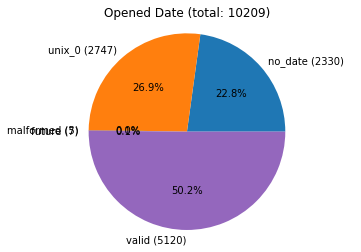

In [12]:
fig1, ax1 = plt.subplots()
ax1.pie(stats.values(), labels=[f"{k} ({v})" for k,v in stats.items()], autopct='%1.1f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title(f'Opened Date (total: {len(df)})')
plt.show()

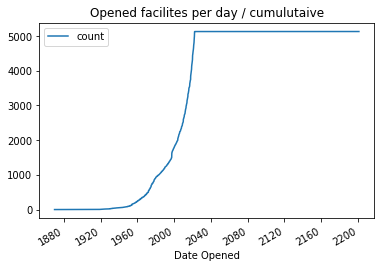

In [13]:
df.groupby('Date Opened').size().cumsum().reset_index(name='count').set_index('Date Opened').plot()
plt.title('Opened facilites per day / cumulutaive')
plt.show()

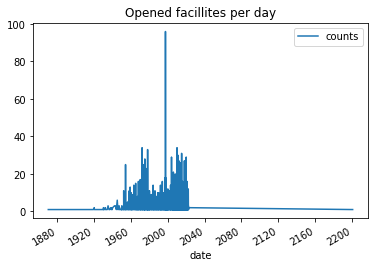

In [14]:
df['Date Opened'].value_counts(dropna=True).rename_axis('date').reset_index(name='counts').set_index('date').plot()
plt.title('Opened facillites per day')
plt.show()

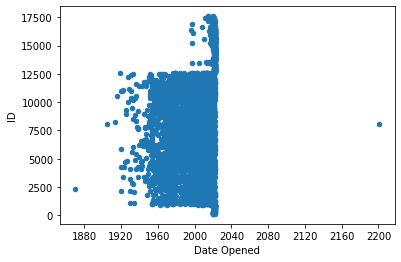

In [15]:
df.plot.scatter(y='ID', x='Date Opened')
plt.show()

In [16]:
# use for check open date agains 
# - Facility Type
# - Operating Status
# - Ownership
# - Region
# - District
# ->  no interesting insights...

#for r in list(df['Facility Type'].unique()):
#    dfx = df[df['Facility Type'] == r]
#    
#    dfx.plot.scatter(y='ID', x='Date Opened')
#    plt.title(r)

# Identify Region ID

In [17]:
regions_gdf = geopandas.read_postgis(f"SELECT * FROM region",
                     geom_col='geometry', con=get_engine())

In [18]:
regions = pd.Series(regions_gdf.region_id.values,index=regions_gdf.name).to_dict()

In [19]:
def get_region_id(name):
    """ Map provided region name to our database to determine region id for referencing. """
    name = name.replace(' Region', '')
    
    if name == 'Dar es Salaam':
        name = 'Dar-es-salaam'
    
    if name in regions:
        return regions[name]
    
    return None

In [20]:
df['region_id_by_name'] = df['Region'].apply(get_region_id)

In [21]:
# Amount of missing region IDs
len(df[df['region_id_by_name'].isna()])

0

In [22]:
region_shapes = dict(zip(regions_gdf.region_id, regions_gdf.geometry))

In [23]:
gdf = geopandas.GeoDataFrame(
        df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude, crs="EPSG:4326"))

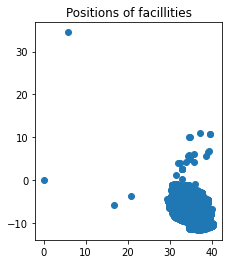

In [24]:
gdf.plot()
plt.title("Positions of facillities")
plt.show()

In [25]:
gdf['Longitude'].max()

40.424474

In [26]:
count = 0
error = 0
wrong_per_region = {}

def check_if_coord_is_inside_region(row):
    global count, error
    lat = row['Latitude']
    lng = row['Longitude']
    region_id = row['region_id_by_name']
    
    if pd.isnull(lat):
        return None

    p = Point(lng, lat)
    
    try:
        if not region_shapes[region_id].contains(p):
            logging.warning(f"Coordinate is not inside given region ({row['Region'] }) for id={row['ID']}")
            count += 1
            
            if region_id in wrong_per_region:
                wrong_per_region[region_id].append(row['ID'])
            else:
                wrong_per_region[region_id] = [row['ID']]
            
    except Exception as e:
        error += 1

df.apply(check_if_coord_is_inside_region, axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
10204    None
10205    None
10206    None
10207    None
10208    None
Length: 10209, dtype: object

In [27]:
print(count)

121


In [28]:
print(error)

101


In [29]:
wrong_per_region

{18: [1489, 4658, 4225, 620, 5497],
 7: [15117,
  2376,
  2807,
  9458,
  3131,
  3479,
  15068,
  4929,
  4033,
  7891,
  8817,
  11209,
  11449,
  904,
  11517,
  11923,
  11944,
  15426,
  10926,
  11464],
 11: [1729],
 1: [2143, 13370, 7274],
 23: [12194],
 19: [14762, 418, 13155, 8496, 6444, 5906, 9969, 10663, 467, 16273],
 16: [12781, 3489, 4241, 5020, 6953, 12523, 1738],
 25: [16079, 13001, 126, 4139, 8333, 16078, 16151, 13557, 10201, 10567, 10641],
 24: [2787, 9508, 11363],
 14: [12958, 9511],
 17: [16032, 4944, 15992, 7370, 9555, 10620],
 10: [13770, 12214],
 21: [3012, 3169, 6343, 14394, 10896],
 9: [16493, 15225],
 12: [4811],
 5: [3825, 7615, 11252, 11619],
 6: [4032, 5462, 6178, 6766, 7496, 8111, 7323, 12012],
 13: [16192, 15519, 7842, 16191, 9698, 10323, 14678, 11639],
 15: [5824, 5910, 8249],
 22: [6265, 14245, 14334],
 4: [8674, 8816, 6078],
 3: [8517, 8065, 9428, 9669, 9673, 1381],
 20: [8668],
 8: [5838],
 2: [8052, 10854],
 26: [6958, 8959, 17375]}

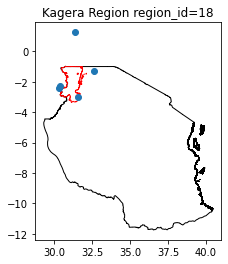

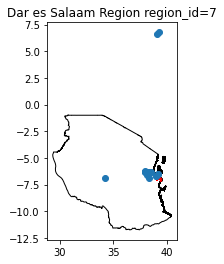

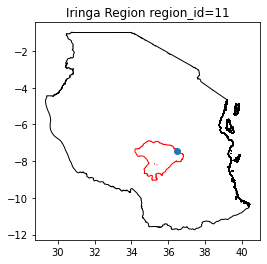

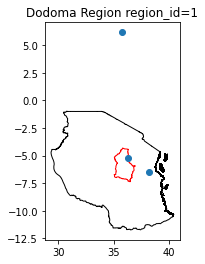

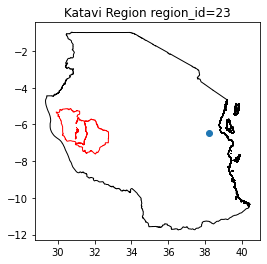

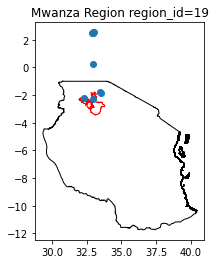

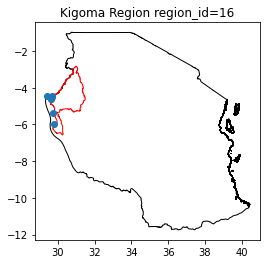

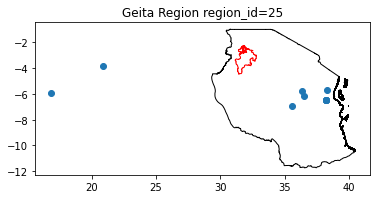

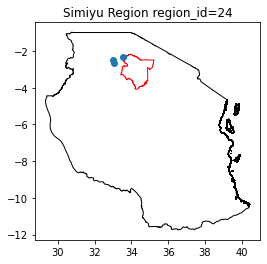

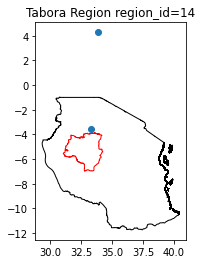

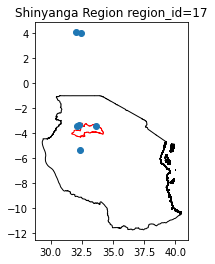

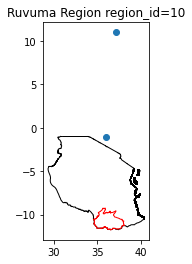

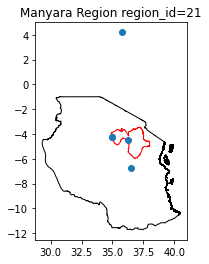

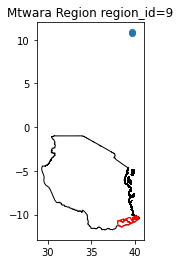

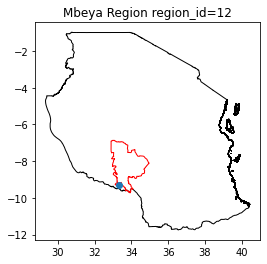

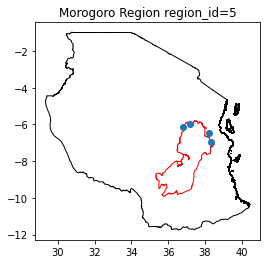

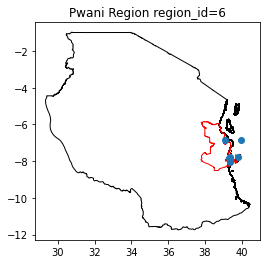

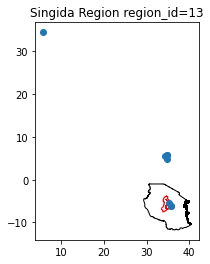

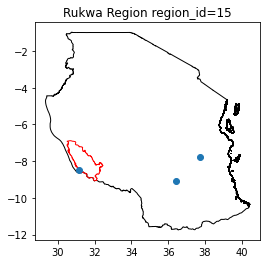

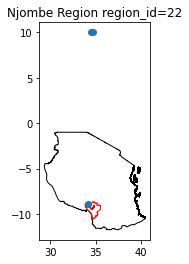

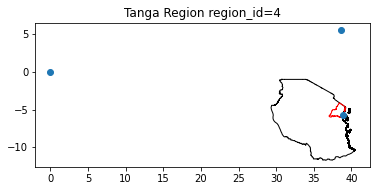

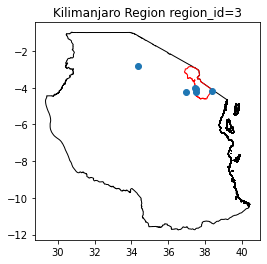

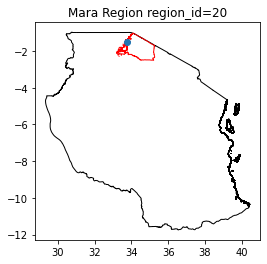

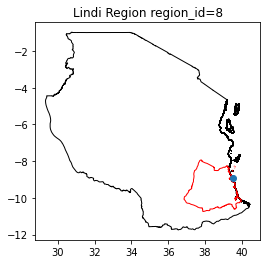

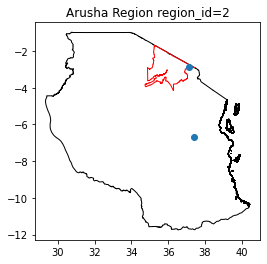

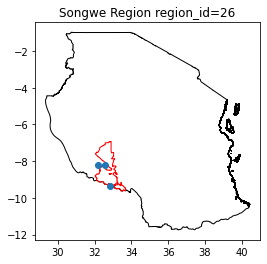

In [30]:
i = 1
taz_gdf = geopandas.read_file('TZA_adm0_tanzanianzima.geojson')

for region_id, wrongs in wrong_per_region.items():
    gdfx = regions_gdf[regions_gdf['region_id'] == region_id]
    
    dfx = df[df['ID'].isin(wrongs)].reset_index()
    gdfxp = geopandas.GeoDataFrame(
        dfx, geometry=geopandas.points_from_xy(dfx.Longitude, dfx.Latitude))
    
    ax = taz_gdf.plot(edgecolor='black', color='none')

    gdfx.plot(ax=ax, edgecolor='red', color='none')
    gdfxp.plot(ax=ax)
    plt.title(f"{dfx.at[0, 'Region']} region_id={region_id}")
    i+=1 
    
    plt.show()

In [31]:
def plot_wrong_region(row_id):
    dfx = df[df['ID'] == row_id].reset_index()
    
    region_id = dfx.at[0, 'region_id_by_name']
    
    gdfx = regions_gdf[regions_gdf['region_id'] == region_id]
    
    gdfxp = geopandas.GeoDataFrame(
        dfx, geometry=geopandas.points_from_xy(dfx.Longitude, dfx.Latitude))
    
    ax = gdfx.plot(edgecolor='black', color='none')
    gdfxp.plot(ax=ax)
    
    plt.show()

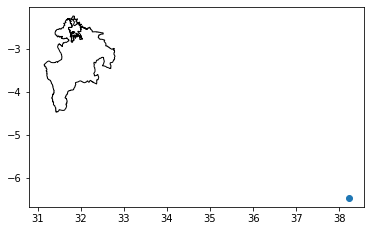

In [32]:
plot_wrong_region(4139)

In [33]:
gdf['Region'].value_counts(dropna=False).rename_axis('unique_values').reset_index(name='counts')

unique_values  counts
0   Dar es Salaam Region    1190
1          Mwanza Region     603
2        Morogoro Region     583
3          Dodoma Region     519
4          Arusha Region     493
5           Tanga Region     480
6     Kilimanjaro Region     459
7           Pwani Region     458
8           Mbeya Region     428
9          Tabora Region     398
10         Ruvuma Region     385
11           Mara Region     369
12         Kagera Region     368
13         Njombe Region     340
14         Kigoma Region     322
15         Iringa Region     311
16      Shinyanga Region     300
17         Mtwara Region     295
18        Singida Region     284
19          Lindi Region     277
20          Geita Region     268
21        Manyara Region     248
22         Simiyu Region     248
23          Rukwa Region     242
24         Songwe Region     231
25         Katavi Region     110

In [34]:
len(gdf)

10209

# District Mapping

In [35]:
districts_gdf = geopandas.read_postgis("SELECT * FROM district",
                     geom_col='geometry', con=get_engine())

In [36]:
districts = pd.Series(districts_gdf.id.values, index=districts_gdf.name).to_dict()

In [37]:
engine = get_engine()

def get_district_id_by_coord(row):
    point = row['geometry']
    
    row['region_id_by_coord'] = None
    row['district_id_by_coord'] = None
    
    # isna() etc WON'T catch an empty geoemetry from geopands!
    if point.is_empty:
        return row
    
    match_district = districts_gdf[districts_gdf['geometry'].contains(point)].reset_index()
    
    if len(match_district) != 1:
        logging.warning(f"Could not match coordinate to district for id={row['ID']}")
        return row
    
    row['region_id_by_coord'] = match_district.at[0, 'region_id']
    row['district_id_by_coord'] = match_district.at[0, 'id']

    return row

In [38]:
gdf2 = gdf.apply(get_district_id_by_coord, axis=1)

In [39]:
gdf['region_id_by_coord'] = gdf2['region_id_by_coord']
gdf['district_id_by_coord'] = gdf2['district_id_by_coord']

In [40]:
na = {}
def get_district_id(name, council=None):
    name = name.replace(' District', '')

    # check how many matches
    c = 0
    t = None
    for d in list(districts.keys()):
        if d.startswith(name):
            c += 1
            t = d
    
    # only one match -> district identified
    if (c == 1):
        name = t
        return districts[name]
    else:
        # more matches, try to differntiate between TC and DC
        name_tc = f"{name} TC"
        if council.endswith(' TC') and name_tc in districts:
            return districts[name_tc]
            
        name_dc = f"{name} DC"
        if council.endswith(' DC') and name_dc in districts:
            return districts[name_dc]
        
        # individual mappings
        if name == 'Kigoma' and council == 'Kigoma Ujiji MC':
            return districts['Kigoma Municipal-Ujiji']
        
        if name in na:
            na[name] += 1
        else:
            na[name] = 1
        return None
    
    return None

In [41]:
na = {}
gdf['district_id_by_name'] = gdf.apply(lambda x: get_district_id(x.District, x.Council), axis=1)

In [42]:
gdf

ID Facility Number  Facility Name  Latitude  Longitude  \
0       1417        113310-7  2001 GEM PLUS -2.563525  32.912659   
1       1419        108548-9           23KJ       NaN        NaN   
2       1420        110967-7           24KJ       NaN        NaN   
3       1422        111824-9         361 KJ       NaN        NaN   
4      13559        120423-9    4POLYCLINIC       NaN        NaN   
...      ...             ...            ...       ...        ...   
10204   1815        108429-2      ZUGIMLOLE -5.325170  31.652449   
10205   1817        114182-9           ZULU       NaN        NaN   
10206   1818        111940-3           ZULU -6.803010  39.126290   
10207   1820        108430-0        ZUNZULI -3.324210  32.839330   
10208   1822        108431-8           ZUZU -6.172144  35.640203   

              Common Name                Region             District  \
0                     NaN         Mwanza Region   Nyamagana District   
1          Jeshini / JWTZ         Kagera Region  Biharamulo District   
2                    24kj         Kigoma Region      Kigoma District   
3                  361 KJ  Dar es Salaam Region   Kinondoni District   
4             4polyclinic  Dar es Salaam Region       Ilala District   
...                   ...                   ...                  ...   
10204           Zugimlole         Tabora Region      Kaliua District   
10205                ZULU  Dar es Salaam Region      Temeke District   
10206                Zulu  Dar es Salaam Region      Ubungo District   
10207  Zunzuli dispensary      Shinyanga Region   Shinyanga District   
10208                Zuzu         Dodoma Region      Dodoma District   

               Council              Ward  ... CTC_ID msd_id  \
0         Nyamagana MC           Butimba  ...    NaN    NaN   
1        Biharamulo DC  Biharamulo Mjini  ...    NaN    NaN   
2      Kigoma Ujiji MC     Mwanga Kusini  ...    NaN    NaN   
3         Kinondoni MC           Makongo  ...    NaN    NaN   
4             Ilala MC            Ukonga  ...    NaN    NaN   
...                ...               ...  ...    ...    ...   
10204        Kaliua DC         Zugimlole  ...    NaN    NaN   
10205        Temeke MC       Mbagala Kuu  ...    NaN    NaN   
10206        Ubungo MC           Msigani  ...    NaN    NaN   
10207     Shinyanga DC            Mwenge  ...    NaN    NaN   
10208        Dodoma MC              Zuzu  ...    NaN    NaN   

                    PostalAddress               OfficialEmail Website  \
0                 P. O. Box 13 81         marcoenos@gmail.com     NaN   
1               BOX 54 BIHARAMULO                         NaN     NaN   
2                          box 85                         NaN     NaN   
3                             NaN                         NaN     NaN   
4                       box 17132  Ipyana.mwakamela@gmail.com     NaN   
...                           ...                         ...     ...   
10204                   Zugimlole                         NaN     NaN   
10205  PO BOX 14629 DAR ES SALAAM    ilona.elisante@gmail.com     NaN   
10206                   14629 DAR    Ilona.elisante@gmail.com     NaN   
10207                         NaN                         NaN     NaN   
10208                        1249                         NaN     NaN   

      region_id_by_name                   geometry region_id_by_coord  \
0                    19  POINT (32.91266 -2.56352)               19.0   
1                    18                POINT EMPTY                NaN   
2                    16                POINT EMPTY                NaN   
3                     7                POINT EMPTY                NaN   
4                     7                POINT EMPTY                NaN   
...                 ...                        ...                ...   
10204                14  POINT (31.65245 -5.32517)               14.0   
10205                 7                POINT EMPTY                NaN   
10206                 7  POINT (39.12

In [43]:
na

{'Njombe': 108,
 'Moshi': 71,
 'Mpanda': 30,
 'Morogoro': 119,
 'Mtwara': 67,
 'Mbeya': 104,
 'Songea': 64,
 'Arusha': 163,
 'Bukoba': 44,
 'Iringa': 51,
 'Musoma': 41,
 'Babati': 28,
 'Arumeru': 66,
 'Shinyanga': 52,
 'Lindi': 45,
 "Nyang'hwale": 30,
 'Singida': 35,
 'Sumbawanga': 42}

In [44]:
taz_gdf = geopandas.read_file('TZA_adm0_tanzanianzima.geojson')

In [45]:
def viz_mismatch(df, key):
    subset_df = df[df['District'] == f'{key} District']
    
    subset_gdf = geopandas.GeoDataFrame(
        subset_df, geometry=geopandas.points_from_xy(subset_df.Longitude, subset_df.Latitude))
    
    districts_gdf = geopandas.read_postgis(f"SELECT * FROM district WHERE name LIKE %s", params=(f"%{key}%",),
                     geom_col='geometry', con=get_engine())
    
    
    fig, ax = plt.subplots(figsize=(12, 4))
    
    #taz_gdf.plot(facecolor="None", edgecolor='black', ax=ax)

    districts_gdf.plot(ax=ax, alpha=0.5, cmap="Pastel1", column='name', edgecolor='black')
    
    subset_gdf.plot(column='Council', ax=ax, marker='x', legend=True)
    
    plt.title(key)
    plt.show()


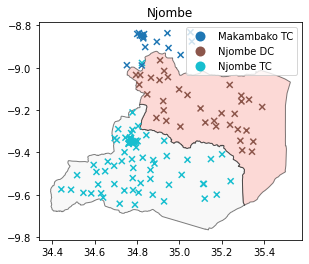

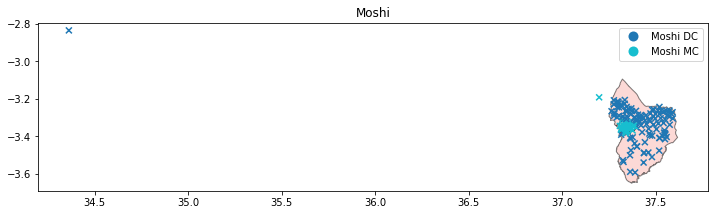

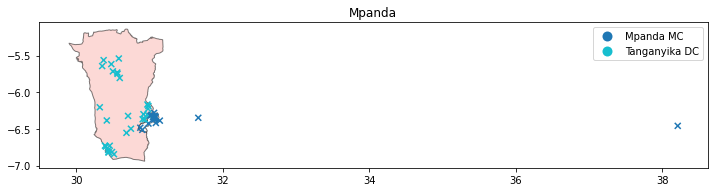

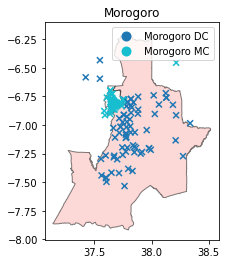

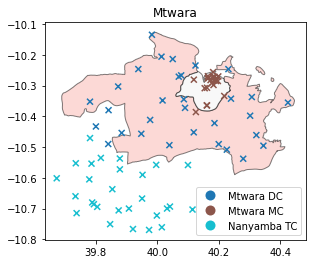

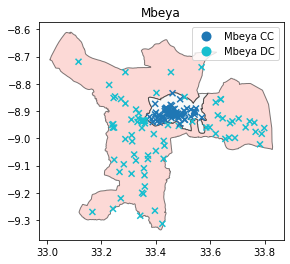

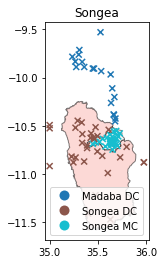

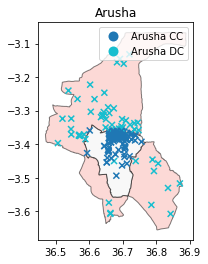

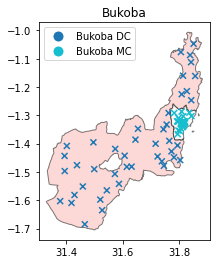

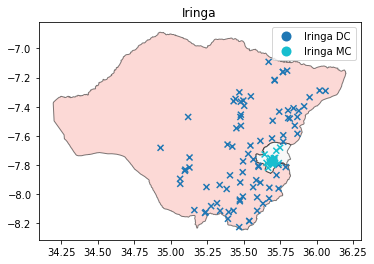

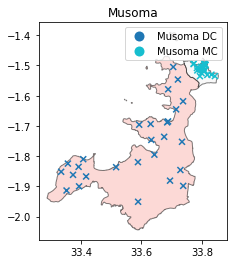

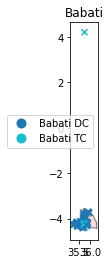

/opt/homebrew/lib/python3.9/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


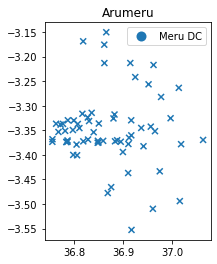

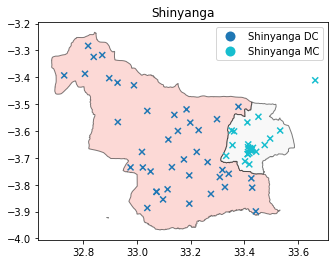

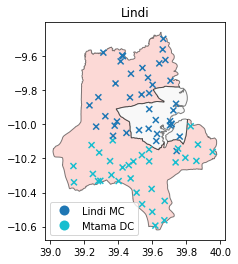

/opt/homebrew/lib/python3.9/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


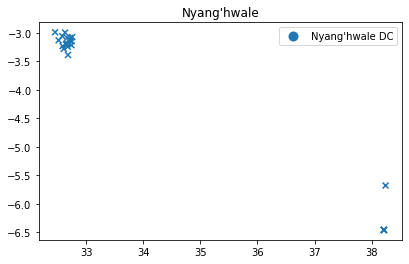

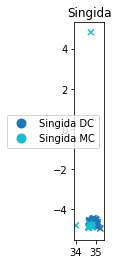

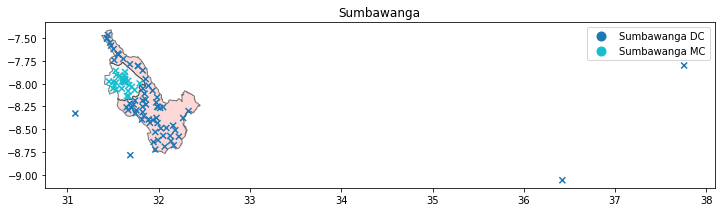

In [46]:
for key, count in na.items():
    viz_mismatch(df, key)

# Analyze mismatch between coord / name based distrcit/region mapping

In [47]:
without_district = gdf[gdf['district_id_by_coord'].isnull() & gdf['district_id_by_name'].isnull()]

In [48]:
print(len(without_district))

225


In [49]:
total = len(gdf)

region_id_by_name = gdf['region_id_by_name'].isnull().sum()
region_id_by_coord = gdf['region_id_by_coord'].isnull().sum()

district_id_by_name = gdf['district_id_by_name'].isnull().sum()
district_id_by_coord = gdf['district_id_by_coord'].isnull().sum()

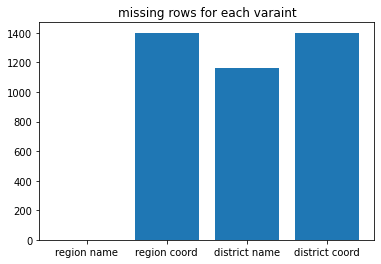

In [50]:
plt.bar(['region name', 'region coord', 'district name', 'district coord'], 
        height=[region_id_by_name, region_id_by_coord, district_id_by_name, district_id_by_coord])
plt.title("missing rows for each varaint")
plt.show()

In [51]:
# name and coord based mismatch for region
not_na_regions = gdf[gdf['region_id_by_name'].notna() & gdf['region_id_by_coord'].notna()]
not_na_regions_missmatch = not_na_regions[not_na_regions['region_id_by_name'] != not_na_regions['region_id_by_coord']]
len(not_na_regions_missmatch)

63

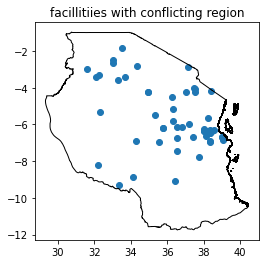

In [52]:
ax = not_na_regions_missmatch.plot()
taz_gdf.plot(facecolor="None", edgecolor='black', ax=ax)
plt.title("facillitiies with conflicting region")
plt.show()

In [53]:
# name and coord based mismatch for district
not_na_district = gdf[gdf['district_id_by_name'].notna() & gdf['district_id_by_coord'].notna()]
not_na_district_missmatch = not_na_district[not_na_district['district_id_by_name'] != not_na_district['district_id_by_coord']]
len(not_na_district_missmatch) 

519

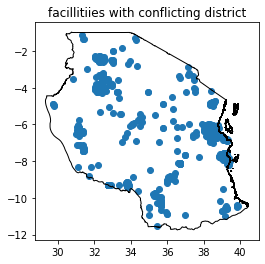

In [54]:
ax = not_na_district_missmatch.plot()
taz_gdf.plot(facecolor="None", edgecolor='black', ax=ax)
plt.title("facillitiies with conflicting district")
plt.show()

In [55]:
# has a valid geoemtry (POINT) but no district/region by coord -> point is OUTSIDE of Tanzania
outside_tanzania = gdf[~gdf['geometry'].is_empty & gdf['district_id_by_coord'].isna()]

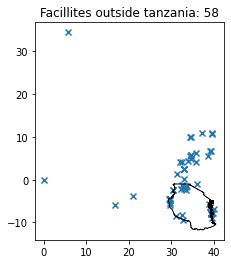

In [56]:
ax = outside_tanzania.plot(marker="x")
taz_gdf.plot(facecolor="None", edgecolor='black', ax=ax)
plt.title(f"Facillites outside tanzania: {len(outside_tanzania)}")
plt.show()

# Get final result set and write to database

In [69]:
def determine_region_id(row):
    
    # prefere region name over coordinate
    #if pd.notna(row['region_id_by_name']):
    #    return row['region_id_by_name']
    
    if pd.notna(row['region_id_by_coord']):
        return row['region_id_by_coord']
    
    return None
    
def determine_dsistrict_id(row):
    
    # prefere region name over coordinate
    #if pd.notna(row['district_id_by_name']):
    #    return row['district_id_by_name']
    
    if pd.notna(row['district_id_by_coord']):
        return row['district_id_by_coord']
    
    return None
    

In [58]:
gdf

ID Facility Number  Facility Name  Latitude  Longitude  \
0       1417        113310-7  2001 GEM PLUS -2.563525  32.912659   
1       1419        108548-9           23KJ       NaN        NaN   
2       1420        110967-7           24KJ       NaN        NaN   
3       1422        111824-9         361 KJ       NaN        NaN   
4      13559        120423-9    4POLYCLINIC       NaN        NaN   
...      ...             ...            ...       ...        ...   
10204   1815        108429-2      ZUGIMLOLE -5.325170  31.652449   
10205   1817        114182-9           ZULU       NaN        NaN   
10206   1818        111940-3           ZULU -6.803010  39.126290   
10207   1820        108430-0        ZUNZULI -3.324210  32.839330   
10208   1822        108431-8           ZUZU -6.172144  35.640203   

              Common Name                Region             District  \
0                     NaN         Mwanza Region   Nyamagana District   
1          Jeshini / JWTZ         Kagera Region  Biharamulo District   
2                    24kj         Kigoma Region      Kigoma District   
3                  361 KJ  Dar es Salaam Region   Kinondoni District   
4             4polyclinic  Dar es Salaam Region       Ilala District   
...                   ...                   ...                  ...   
10204           Zugimlole         Tabora Region      Kaliua District   
10205                ZULU  Dar es Salaam Region      Temeke District   
10206                Zulu  Dar es Salaam Region      Ubungo District   
10207  Zunzuli dispensary      Shinyanga Region   Shinyanga District   
10208                Zuzu         Dodoma Region      Dodoma District   

               Council              Ward  ... CTC_ID msd_id  \
0         Nyamagana MC           Butimba  ...    NaN    NaN   
1        Biharamulo DC  Biharamulo Mjini  ...    NaN    NaN   
2      Kigoma Ujiji MC     Mwanga Kusini  ...    NaN    NaN   
3         Kinondoni MC           Makongo  ...    NaN    NaN   
4             Ilala MC            Ukonga  ...    NaN    NaN   
...                ...               ...  ...    ...    ...   
10204        Kaliua DC         Zugimlole  ...    NaN    NaN   
10205        Temeke MC       Mbagala Kuu  ...    NaN    NaN   
10206        Ubungo MC           Msigani  ...    NaN    NaN   
10207     Shinyanga DC            Mwenge  ...    NaN    NaN   
10208        Dodoma MC              Zuzu  ...    NaN    NaN   

                    PostalAddress               OfficialEmail Website  \
0                 P. O. Box 13 81         marcoenos@gmail.com     NaN   
1               BOX 54 BIHARAMULO                         NaN     NaN   
2                          box 85                         NaN     NaN   
3                             NaN                         NaN     NaN   
4                       box 17132  Ipyana.mwakamela@gmail.com     NaN   
...                           ...                         ...     ...   
10204                   Zugimlole                         NaN     NaN   
10205  PO BOX 14629 DAR ES SALAAM    ilona.elisante@gmail.com     NaN   
10206                   14629 DAR    Ilona.elisante@gmail.com     NaN   
10207                         NaN                         NaN     NaN   
10208                        1249                         NaN     NaN   

      region_id_by_name                   geometry region_id_by_coord  \
0                    19  POINT (32.91266 -2.56352)               19.0   
1                    18                POINT EMPTY                NaN   
2                    16                POINT EMPTY                NaN   
3                     7                POINT EMPTY                NaN   
4                     7                POINT EMPTY                NaN   
...                 ...                        ...                ...   
10204                14  POINT (31.65245 -5.32517)               14.0   
10205                 7                POINT EMPTY                NaN   
10206                 7  POINT (39.12

In [70]:
gdf['region_id'] = gdf.apply(determine_region_id, axis=1)
gdf['district_id'] = gdf.apply(determine_dsistrict_id, axis=1)

In [71]:
remove = gdf[gdf['region_id'].isna() | gdf['district_id'].isna()]
final = gdf[gdf['region_id'].notna() & gdf['district_id'].notna()]

<AxesSubplot:>

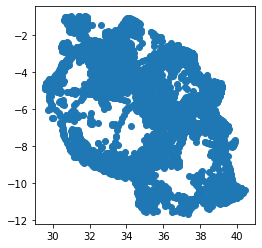

In [72]:
final.plot()

In [74]:
final['region_id'].value_counts(dropna=False).rename_axis('unique_values').reset_index(name='counts')

unique_values  counts
0             7.0     860
1            19.0     510
2             5.0     489
3             1.0     436
4             2.0     433
5             3.0     419
6             6.0     409
7             4.0     408
8            12.0     395
9            14.0     352
10           18.0     344
11           10.0     342
12           20.0     312
13           22.0     298
14           16.0     293
15           11.0     282
16            8.0     256
17            9.0     255
18           13.0     247
19           21.0     239
20           24.0     237
21           25.0     233
22           17.0     228
23           26.0     215
24           15.0     215
25           23.0     101

In [75]:
final['district_id'].value_counts(dropna=False).rename_axis('unique_values').reset_index(name='counts')

unique_values  counts
0              8.0     258
1              9.0     212
2             10.0     181
3            193.0     162
4              2.0     130
..             ...     ...
179          188.0      12
180          181.0      11
181           40.0      11
182           89.0      10
183          160.0       9

[184 rows x 2 columns]

In [105]:
def count_region(df):
    re = []
    
    for k, v in regions_gdf.iterrows():
        dfx = df[df['region_id'] == v['region_id']]
        re.append({
            'id': v['region_id'],
            'name': v['name'],
            'count': len(dfx),
            'geometry': v['geometry']
        })
    
    return re

In [107]:
d = count_region(final)

<AxesSubplot:>

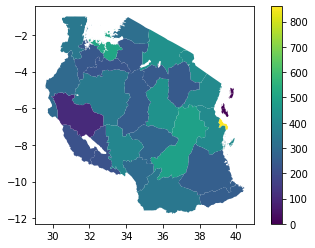

In [108]:
count_region = geopandas.GeoDataFrame(d)
count_region.plot(column='count', legend=True)

In [120]:
# count per distrcit

def count_district(df, year=None):
    re = []
    
    for k, v in districts_gdf.iterrows():
        dfx = df[df['district_id'] == v['id']]
        re.append({
            'id': v['id'],
            'name': v['name'],
            'count': len(dfx),
            'geometry': v['geometry'],
            'year': year
        })
    
    return re
    

In [90]:
count_all = geopandas.GeoDataFrame(count_district(final))

<AxesSubplot:>

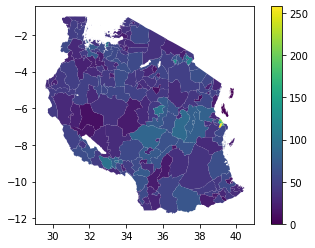

In [94]:
count_all.plot(column='count', legend=True)

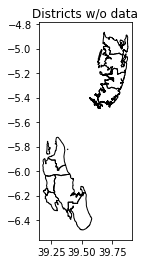

In [100]:
count_all[count_all['count'] == 0].plot(edgecolor='black', facecolor='none')
plt.title('Districts w/o data')
plt.show()

In [114]:
# group by year/distrcit
with_date = final[final['Date Opened'].notna()]
with_date['year'] = with_date['Date Opened'].apply(lambda x: x.year)

In [112]:
len(with_date)

4379

In [121]:
per_year = []
for y in list(with_date['year'].unique()):
    dfx = with_date[with_date['year'] == y]
    per_year += count_district(dfx, y)

In [126]:
per_year_df = geopandas.GeoDataFrame(per_year)

In [155]:
per_year_df

id         name  count  \
0        1    Arusha DC      0   
1        2    Arusha MC      0   
2        3    Karatu DC      2   
3        4   Longido DC      0   
4        5      Meru DC      0   
...    ...          ...    ...   
20470  191    Songwe DC      0   
20471  192    Tarime TC      0   
20472  193    Ubungo MC      0   
20473  194   Butiama DC      0   
20474  195  Magharibi A      0   

                                                geometry  year  
0      MULTIPOLYGON (((36.79314 -3.39499, 36.79285 -3...  2001  
1      POLYGON ((36.63328 -3.36609, 36.63297 -3.36625...  2001  
2      POLYGON ((35.88714 -3.26276, 35.88595 -3.26604...  2001  
3      MULTIPOLYGON (((36.35809 -3.05992, 36.35823 -3...  2001  
4      POLYGON ((36.90033 -3.05354, 36.90150 -3.05390...  2001  
...                                                  ...   ...  
20470  POLYGON ((32.89625 -6.93692, 32.89573 -6.96095...  1919  
20471  POLYGON ((34.38746 -1.28793, 34.39209 -1.28903...  1919  
20472  POLYGON ((39.16298 -6.69287, 39.16315 -6.69296...  1919  
20473  POLYGON ((34.29664 -1.46716, 34.29644 -1.46806...  1919  
20474  POLYGON ((39.27725 -6.17416, 39.27696 -6.17398...  1919  

[20475 rows x 5 columns]

In [215]:
hfind_df = per_year_df[per_year_df['id'] == 1].reset_index()

In [216]:
hfind_df

index  id       name  count  \
0        0   1  Arusha DC      0   
1      195   1  Arusha DC      0   
2      390   1  Arusha DC      0   
3      585   1  Arusha DC      1   
4      780   1  Arusha DC      0   
..     ...  ..        ...    ...   
100  19500   1  Arusha DC      0   
101  19695   1  Arusha DC      0   
102  19890   1  Arusha DC      0   
103  20085   1  Arusha DC      0   
104  20280   1  Arusha DC      0   

                                              geometry  year  
0    MULTIPOLYGON (((36.79314 -3.39499, 36.79285 -3...  2001  
1    MULTIPOLYGON (((36.79314 -3.39499, 36.79285 -3...  2014  
2    MULTIPOLYGON (((36.79314 -3.39499, 36.79285 -3...  2013  
3    MULTIPOLYGON (((36.79314 -3.39499, 36.79285 -3...  2015  
4    MULTIPOLYGON (((36.79314 -3.39499, 36.79285 -3...  2016  
..                                                 ...   ...  
100  MULTIPOLYGON (((36.79314 -3.39499, 36.79285 -3...  1937  
101  MULTIPOLYGON (((36.79314 -3.39499, 36.79285 -3...  2201  
102  MULTIPOLYGON (((36.79314 -3.39499, 36.79285 -3...  1931  
103  MULTIPOLYGON (((36.79314 -3.39499, 36.79285 -3...  1915  
104  MULTIPOLYGON (((36.79314 -3.39499, 36.79285 -3...  1919  

[105 rows x 6 columns]

In [267]:
def viz_healtfacilities_per_distrct(df, district_id):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    hf_in_d_df = df[df['district_id'] == district_id].reset_index()
    district = hf_in_d_df.at[0, 'Region']
    

    # amount w/o date
    without_opening_date = len(hf_in_d_df[hf_in_d_df['Date Opened'].isnull()])


    # only with date
    with_date = hf_in_d_df[hf_in_d_df['Date Opened'].notna()]
    with_date['year'] = with_date['Date Opened'].apply(lambda x: x.year)

    #with_date.index = pd.to_datetime(with_date['year'], format='%Y')
    #with_date = with_date.sort_index()

    all_per_year = with_date.groupby('year').size().reset_index(name='count')
    all_per_year.index = pd.to_datetime(all_per_year['year'], format='%Y')

    display(all_per_year)

    all_per_year['count'].plot.bar(ax=ax1)
    ax1.set_title('Openings per year')


    all_per_year['count_cum'] = all_per_year['count'].cumsum()
    all_per_year['count_cum'] += without_opening_date

    all_per_year['count_cum'].plot(ax=ax2)
    ax2.set_title('Cumulative openings per year with unkown date as base')

    
    fig.suptitle(f'Healt facilities in {district}')
    plt.show()
    
    

year  count
year                   
1999-01-01  1999      1
2000-01-01  2000      1
2017-01-01  2017      1
2020-01-01  2020      1
2021-01-01  2021      2

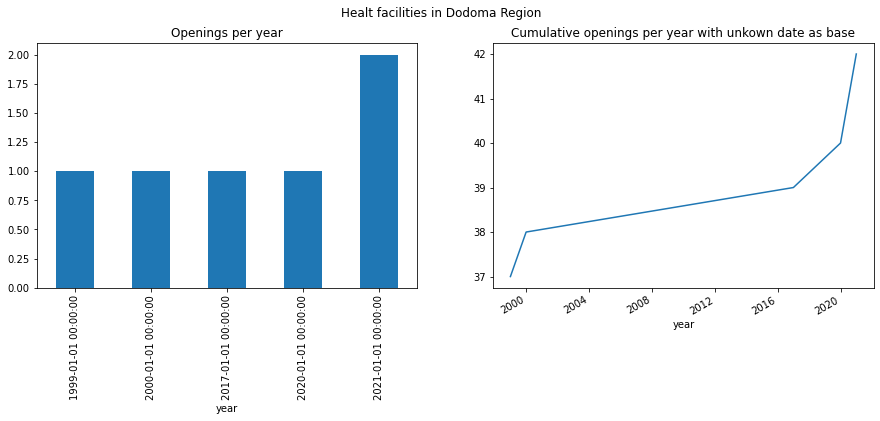

In [269]:
viz_healtfacilities_per_distrct(final, 15)

# Write to database

In [65]:
final.to_postgis('healthfacilities', con=get_engine())